####### MPC ########
RMSE  Weibull MPC: 0.01604870337281886
RMSE   Normal MPC: 0.005763227079487383
RMSE    Gamma MPC: 0.0057382135056323405
RMSE Lognormal MPC: 0.00955634741080571


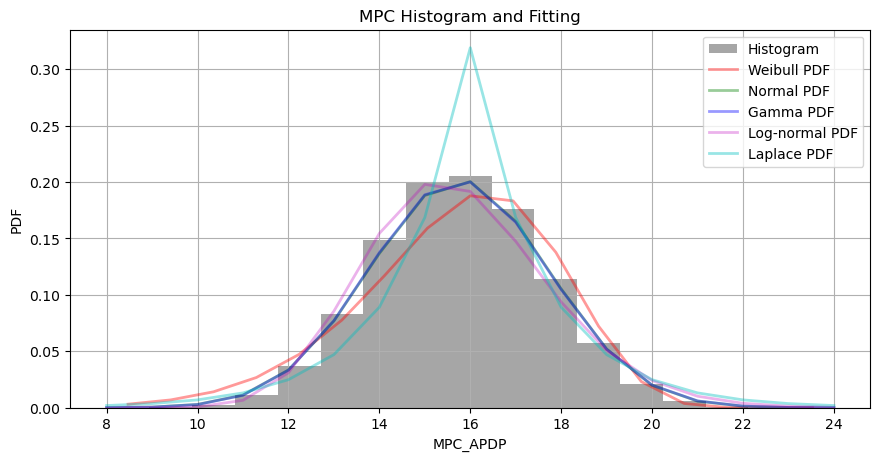

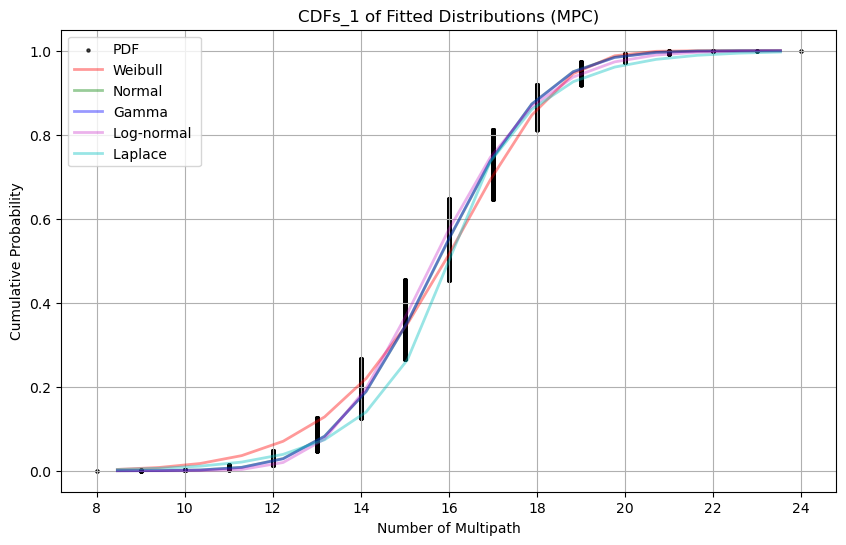

####### RMS DS ########
RMSE  Weibull RMS DS: 0.0008195740648598679
RMSE   Normal RMS DS: 0.0006747279460851223
RMSE    Gamma RMS DS: 0.0006779121358249475
RMSE Lognormal RMS DS: 0.0013128755877235621
RMSE  Laplace RMS DS: 0.001199864835148144


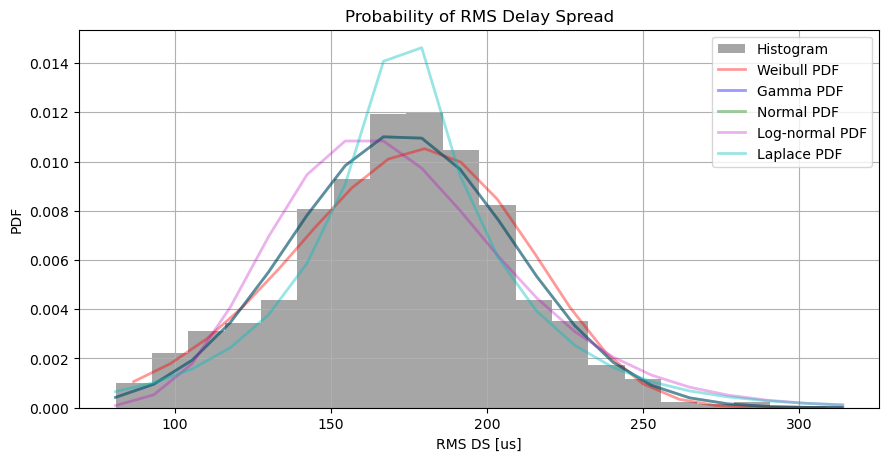

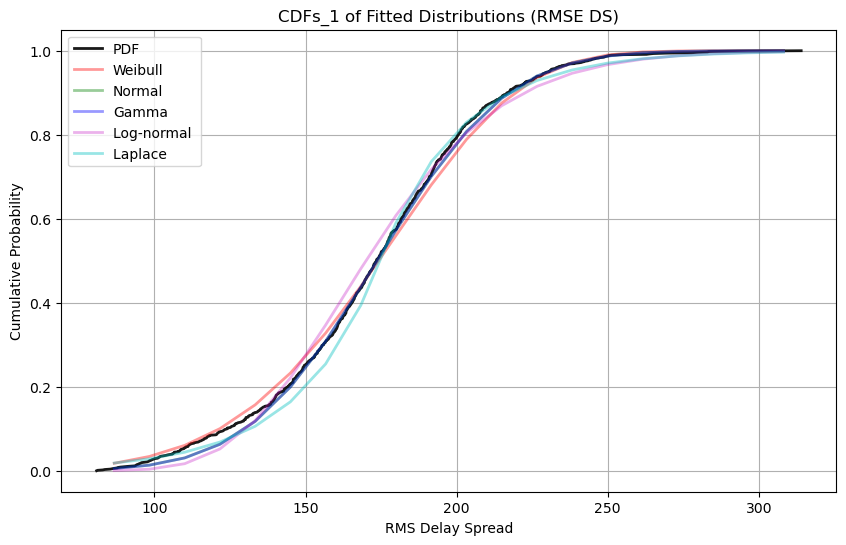

####### Coherence Bandwidth ########
RMSE  Weibull coherence bandwidth: 4.575768038791514e-07
RMSE   Normal coherence bandwidth: 4.026379247401726e-07
RMSE    Gamma coherence bandwidth: 1.0356520471395107e-06
RMSE Lognormal coherence bandwidth: 2.495093378235419e-07
RMSE  Laplace coherence bandwidth: 2.801194285663871e-07


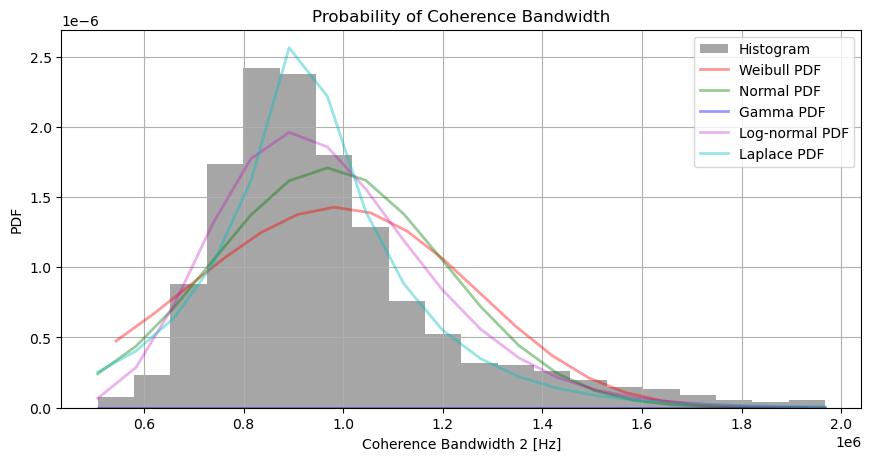

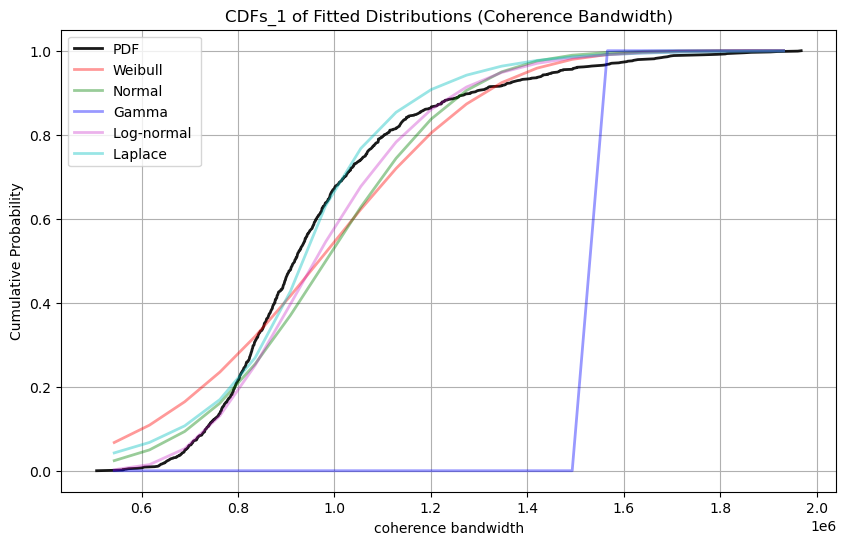

In [15]:
#%%

from matplotlib.pylab import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats as stats
import os
import DelaySpread_und_RMS
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import weibull_min, norm, gamma, laplace
from sklearn.metrics import mean_squared_error
import pickle


#Data 
data_flat = DelaySpread_und_RMS.data.flatten()
num_milliseconds = DelaySpread_und_RMS.num_milliseconds
num_delays = DelaySpread_und_RMS.num_delays
number_1 = DelaySpread_und_RMS.number_1
number_2 = DelaySpread_und_RMS.number_2
with open('all_peaks_for_every_1.pkl', 'rb') as f:
    peaks = pickle.load(f)
#print(f"All peaks: {peaks}")
num_peaks_ms = []
#print(num_MPC)


delays =  DelaySpread_und_RMS.delays

RMS_DS_2 =  DelaySpread_und_RMS.rms_delay_spread_array_1
RMS_DS_2_per_second = []
Bc_2 =  np.load('co_bandwidth_of_every_24_ms.npy')
Bc_2_per_second = []

#Functions


def Weibull (val, num_bin):
    val = np.ravel(val)
    shape, loc, scale = weibull_min.fit(val, floc=0)
    bin_no = num_bin
    data_entries, bins = np.histogram(val, bin_no)
    bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
    pdf = weibull_min.pdf(bincenters, shape, loc=loc, scale=scale)
    cdf = weibull_min.cdf(bincenters, shape, loc=loc, scale=scale)

    return pdf,  bincenters, cdf

def Normal (val, num_bin):
    val = np.ravel(val)
    mu, std = stats.norm.fit(val)
    num_bins = int(num_bin)
    x = np.linspace(min(val), max(val), num_bins)
    pdf = norm.pdf(x, mu, std)
    cdf = norm.cdf(x, mu, std)
    return pdf, x ,cdf

def gamma_function (val, num_bin):
    val = np.ravel(val)
    shape, loc, scale = stats.gamma.fit(val)
    x = np.linspace(min(val), max(val), num_bin)
    pdf = gamma.pdf(x, shape, loc=loc, scale=scale)
    cdf = gamma.cdf(x, shape, loc=loc, scale=scale)

    return pdf, x ,cdf

def log (val, num_bin):
    val = np.ravel(val)
    abs_data = np.abs(val)
    abs_data = abs_data[abs_data > 0]
    shape, loc, scale = stats.lognorm.fit(abs_data, floc=0)
    x = np.linspace(min(abs_data), max(abs_data), num_bin)
    pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)
    cdf = stats.lognorm.cdf(x, shape, loc=loc, scale=scale)

    return pdf, x ,cdf

def laplace_function (val, num_bin):
    val = np.ravel(val)
    loc, scale = stats.laplace.fit(val)
    x = np.linspace(min(val), max(val), num_bin)
    pdf = laplace.pdf(x, loc, scale)
    cdf = laplace.cdf(x, loc, scale)

    return pdf, x ,cdf

def calculate_rmse(hist, val):
    rmse = np.sqrt(mean_squared_error(hist, val))
    return rmse

def CDF (val,num_bin):
    res_freq = stats.relfreq(val,numbins = num_bin)
    pdf_value = res_freq.frequency
    cdf_data = np.cumsum(pdf_value)
    x = res_freq.lowerlimit + np.linspace(0, res_freq.binsize * res_freq.frequency.size, res_freq.frequency.size)


    return  cdf_data

def CDF_1 (val):
    val_sorted = np.sort(val)
    p = 1.*np.arange(len(val_sorted))/(len(val_sorted)-1)

    return val_sorted, p


################ peak APDP   ###############################################################################

num_bin = 17
num_MPC = [len(peaks) for peaks in peaks] 

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.25)
hist_vals, bins, patches= plt.hist(num_MPC, bins=num_bin, density=True,alpha=0.7, color='gray',label='Histogram')
# Fit the updated data
weibull_pdf, x_vals_wb, cdf_weibull, = Weibull(num_MPC,num_bin)
normal_pdf, x_vals_n,cdf_normal = Normal(num_MPC,num_bin)
gamma_pdf, x_vals_g,cdf_gamma = gamma_function(num_MPC,num_bin)
lognorm_pdf, x_vals_ln,cdf_lognormal = log(num_MPC,num_bin)
laplace_pdf, x_vals_lp,cdf_laplace = laplace_function(num_MPC,num_bin)

bin_centers = 0.5 * (bins[1:] + bins[:-1])

#Error calculation

#RMSE
rmse_weibull = calculate_rmse(hist_vals, weibull_pdf)
rmse_normal = calculate_rmse(hist_vals, normal_pdf)
rmse_gamma = calculate_rmse(hist_vals, gamma_pdf)
rmse_lognormal = calculate_rmse(hist_vals, lognorm_pdf)
rmse_laplace = calculate_rmse(hist_vals, laplace_pdf)

print(f"####### MPC ########")
print(f'RMSE  Weibull MPC: {rmse_weibull}')
print(f'RMSE   Normal MPC: {rmse_normal}')
print(f'RMSE    Gamma MPC: {rmse_gamma}')
print(f'RMSE Lognormal MPC: {rmse_lognormal}')

    # Plot the fitting curves
plt.plot(x_vals_wb, weibull_pdf, 'r-', lw=2, alpha=0.4, label='Weibull PDF')
plt.plot(x_vals_n, normal_pdf, 'g-', lw=2, alpha=0.4, label='Normal PDF')
plt.plot(x_vals_g, gamma_pdf, 'b-', lw=2, alpha=0.4, label='Gamma PDF')
plt.plot(x_vals_ln, lognorm_pdf, 'm-', lw=2, alpha=0.3, label='Log-normal PDF')
plt.plot(x_vals_lp, laplace_pdf, 'c-', lw=2, alpha=0.4, label='Laplace PDF')

plt.title(f"MPC Histogram and Fitting")
plt.xlabel('MPC_APDP')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)



#CDF
sorted,p_h = CDF_1(num_MPC)
plt.figure(figsize=(10, 6))
plt.scatter(sorted,p_h, color='k', s=5, alpha=0.7, label='PDF')
plt.plot(bin_centers,cdf_weibull, 'r-', lw=2, alpha=0.4, label='Weibull')
plt.plot(bin_centers,cdf_normal, 'g-', lw=2, alpha=0.4, label='Normal')
plt.plot(bin_centers,cdf_gamma, 'b-', lw=2, alpha=0.4, label='Gamma')
plt.plot(bin_centers,cdf_lognormal, 'm-', lw=2, alpha=0.3, label='Log-normal ')
plt.plot(bin_centers,cdf_laplace, 'c-', lw=2, alpha=0.4, label='Laplace ')
plt.title('CDFs_1 of Fitted Distributions (MPC)')
plt.xlabel('Number of Multipath')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)


'''plt.figure(figsize=(10, 6))
cdf_0 = CDF(num_MPC,num_bin)
plt.plot(bin_centers, cdf_0, 'k-', lw=2, alpha=0.9, label='Data')
plt.plot(bin_centers, cdf_weibull, 'r-', lw=2, alpha=0.4, label='Weibull')
plt.plot(bin_centers, cdf_normal, 'g-', lw=2, alpha=0.4, label='Normal')
plt.plot(bin_centers, cdf_gamma, 'b-', lw=2, alpha=0.4, label='Gamma')
plt.plot(bin_centers, cdf_lognormal, 'm-', lw=2, alpha=0.3, label='Log-normal ')
plt.plot(bin_centers, cdf_laplace, 'c-', lw=2, alpha=0.4, label='Laplace ')

plt.title('CDFs of Fitted Distributions (MPC)')
plt.xlabel('Number of Multipath')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)'''
plt.show()

################ rms DS Frank   ###############################################################################
num_bin_1 = 20
RMS_DS_2 = RMS_DS_2*1e9
RMS_DS_2 = np.array([RMS_DS_2]).flatten()
#print (f'RMS DS :{RMS_DS_2}')

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.25)
hist_5, bins_5, patches_5= plt.hist(RMS_DS_2, bins=num_bin_1, density=True,alpha=0.7, color='gray',label='Histogram')
bin_centers_5 = 0.5 * (bins_5[1:] + bins_5[:-1])
#print (f'rms ds:{hist_5}')
# Fit the updated data
weibull_5, x_vals_wb_5,cdf_weibull_5 = Weibull(RMS_DS_2,num_bin_1)
normal_5, x_vals_n_5,cdf_normal_5 = Normal(RMS_DS_2,num_bin_1)
gamma_5, x_vals_g_5,cdf_gamma_5 = gamma_function(RMS_DS_2,num_bin_1)
lognorm_5, x_vals_ln_5,cdf_lognormal_5 = log(RMS_DS_2,num_bin_1)
laplace_5, x_vals_lp_5,cdf_laplace_5 = laplace_function(RMS_DS_2,num_bin_1)

#RMSE
rmse_weibull_5 = calculate_rmse(hist_5, weibull_5)
rmse_normal_5 = calculate_rmse(hist_5, normal_5)
rmse_gamma_5 = calculate_rmse(hist_5, gamma_5)
rmse_lognormal_5 = calculate_rmse(hist_5, lognorm_5)
rmse_laplace_5 = calculate_rmse(hist_5, laplace_5)
print(f"####### RMS DS ########")
print(f'RMSE  Weibull RMS DS: {rmse_weibull_5}')
print(f'RMSE   Normal RMS DS: {rmse_normal_5}')
print(f'RMSE    Gamma RMS DS: {rmse_gamma_5}')
print(f'RMSE Lognormal RMS DS: {rmse_lognormal_5}')
print(f'RMSE  Laplace RMS DS: {rmse_laplace_5}') 


# Plot the fitting curves
plt.plot(x_vals_wb_5, weibull_5, 'r-', lw=2, alpha=0.4, label='Weibull PDF')
plt.plot(x_vals_n_5, normal_5, 'g-', lw=2, alpha=0.4, label='Normal PDF')
plt.plot(x_vals_g_5, gamma_5, 'b-', lw=2, alpha=0.4, label='Gamma PDF')
plt.plot(x_vals_ln_5, lognorm_5, 'm-', lw=2, alpha=0.3, label='Log-normal PDF')
plt.plot(x_vals_lp_5, laplace_5, 'c-', lw=2, alpha=0.4, label='Laplace PDF')

plt.title("Probability of RMS Delay Spread")
plt.xlabel('RMS DS [us]')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)




#CDF
sorted_5,p_h_5 = CDF_1(RMS_DS_2)
plt.figure(figsize=(10, 6))
plt.plot(sorted_5,p_h_5, 'k-', lw=2, alpha=0.9, label='PDF')
plt.plot(bin_centers_5,cdf_weibull_5, 'r-', lw=2, alpha=0.4, label='Weibull')
plt.plot(bin_centers_5,cdf_normal_5, 'g-', lw=2, alpha=0.4, label='Normal')
plt.plot(bin_centers_5,cdf_gamma_5, 'b-', lw=2, alpha=0.4, label='Gamma')
plt.plot(bin_centers_5,cdf_lognormal_5, 'm-', lw=2, alpha=0.3, label='Log-normal ')
plt.plot(bin_centers_5,cdf_laplace_5, 'c-', lw=2, alpha=0.4, label='Laplace ')
plt.title('CDFs_1 of Fitted Distributions (RMSE DS)')
plt.xlabel('RMS Delay Spread')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)


'''plt.figure(figsize=(10, 6))
cdf_50 = CDF(RMS_DS_2,num_bin_1)
plt.plot(bin_centers_5, cdf_50, 'k-', lw=2, alpha=0.9, label='Data')
plt.plot(bin_centers_5, cdf_weibull_5, 'g-', lw=2, alpha=0.4, label='Weibull')
plt.plot(bin_centers_5, cdf_normal_5, 'r-', lw=2, alpha=0.4, label='Normal')
plt.plot(bin_centers_5, cdf_gamma_5, 'b-', lw=2, alpha=0.4, label='Gamma')
plt.plot(bin_centers_5, cdf_lognormal_5, 'm-', lw=2, alpha=0.3, label='Log-normal ')
plt.plot(bin_centers_5, cdf_laplace_5, 'c-', lw=2, alpha=0.4, label='Laplace ')

plt.title('CDFs of Fitted Distributions (RMSE DS)')
plt.xlabel('RMS Delay Spread')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)'''
plt.show()

################ coherence bandwidth Frank   ############################################################################### 
num_bin = num_bin_1
Bc_2 = np.array(Bc_2).flatten()

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.1, bottom=0.25)
hist_7, bins_7, patches_7 = plt.hist(Bc_2, bins=num_bin_1, density=True, alpha=0.7, color='gray', label='Histogram')
bin_centers_7 = 0.5 * (bins_7[1:] + bins_7[:-1])
#print (hist_7)
# Fit the updated data
weibull_7, x_vals_wb_7,cdf_weibull_7 = Weibull(Bc_2,num_bin)
normal_7, x_vals_n_7,cdf_normal_7 = Normal(Bc_2,num_bin)
gamma_7, x_vals_g_7,cdf_gamma_7 = gamma_function(Bc_2,num_bin)
lognorm_7, x_vals_ln_7,cdf_lognormal_7 = log(Bc_2,num_bin)
laplace_7, x_vals_lp_7,cdf_laplace_7= laplace_function(Bc_2,num_bin)

#RMSE
rmse_weibull_7 = calculate_rmse(hist_7, weibull_7)
rmse_normal_7 = calculate_rmse(hist_7, normal_7)
rmse_gamma_7 = calculate_rmse(hist_7, gamma_7)
rmse_lognormal_7 = calculate_rmse(hist_7, lognorm_7)
rmse_laplace_7 = calculate_rmse(hist_7, laplace_7)
print(f"####### Coherence Bandwidth ########")
print(f'RMSE  Weibull coherence bandwidth: {rmse_weibull_7}')
print(f'RMSE   Normal coherence bandwidth: {rmse_normal_7}')
print(f'RMSE    Gamma coherence bandwidth: {rmse_gamma_7}')
print(f'RMSE Lognormal coherence bandwidth: {rmse_lognormal_7}')
print(f'RMSE  Laplace coherence bandwidth: {rmse_laplace_7}') 


    # Plot the fitting curves
plt.plot(x_vals_wb_7, weibull_7, 'r-', lw=2, alpha=0.4, label='Weibull PDF')
plt.plot(x_vals_n_7, normal_7, 'g-', lw=2, alpha=0.4, label='Normal PDF')
plt.plot(x_vals_g_7, gamma_7, 'b-', lw=2, alpha=0.4, label='Gamma PDF')
plt.plot(x_vals_ln_7, lognorm_7, 'm-', lw=2, alpha=0.3, label='Log-normal PDF')
plt.plot(x_vals_lp_7, laplace_7, 'c-', lw=2, alpha=0.4, label='Laplace PDF')


plt.title("Probability of Coherence Bandwidth")
plt.xlabel('Coherence Bandwidth 2 [Hz]')
plt.ylabel('PDF')
plt.legend()
plt.grid(True)



#CDF
sorted_7,p_h_7 = CDF_1(Bc_2)
plt.figure(figsize=(10, 6))
plt.plot(sorted_7,p_h_7, 'k-', lw=2, alpha=0.9, label='PDF')
plt.plot(bin_centers_7,cdf_weibull_7, 'r-', lw=2, alpha=0.4, label='Weibull')
plt.plot(bin_centers_7,cdf_normal_7, 'g-', lw=2, alpha=0.4, label='Normal')
plt.plot(bin_centers_7,cdf_gamma_7, 'b-', lw=2, alpha=0.4, label='Gamma')
plt.plot(bin_centers_7,cdf_lognormal_7, 'm-', lw=2, alpha=0.3, label='Log-normal ')
plt.plot(bin_centers_7,cdf_laplace_7, 'c-', lw=2, alpha=0.4, label='Laplace ')
plt.title('CDFs_1 of Fitted Distributions (Coherence Bandwidth)')
plt.xlabel('coherence bandwidth')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)



'''cdf_70 = CDF(Bc_2,num_bin_1)
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_7, cdf_70, 'k-', lw=2, alpha=0.9, label='Data')
plt.plot(bin_centers_7, cdf_weibull_7, 'r-', lw=2, alpha=0.4, label='Weibull')
plt.plot(bin_centers_7, cdf_normal_7, 'g-', lw=2, alpha=0.4, label='Normal')
plt.plot(bin_centers_7, cdf_gamma_7, 'b-', lw=2, alpha=0.4, label='Gamma')
plt.plot(bin_centers_7, cdf_lognormal_7, 'm-', lw=2, alpha=0.3, label='Log-normal ')
plt.plot(bin_centers_7, cdf_laplace_7, 'c-', lw=2, alpha=0.4, label='Laplace ')

plt.title('CDFs of Fitted Distributions (Coherence Bandwidth)')
plt.xlabel('coherence bandwidth')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
'''


plt.show()